In [1]:
import numpy as np
import matplotlib.pyplot as plt

The network consists of a single layer of 180 neurons that receive activation from both exogenous inputs and lateral connections.

### Input activation
#### equation (7)

On simulated trial *n*, the mean input activation to neuron *i* is a function of the difference between the target location *$\theta(n)$* and the preferred direction of the neuron *$\theta_i^*$*


target: *$I_i(n)$*, mean activation of unit i  
baseline: *$I_0$*, baseline input rate  
gain: *$\gamma$*, input gain  
target: *$\theta(n)$*,  target location  
preference: *$\theta_i^*$*, prefered direction of unit i  
spread: *$\omega_I$*, spread of input activation (full-width-half-magnitude / FWHM)  


In [2]:
# define input activation function

def input_activation(target, preference, baseline=0, gain=1, spread=12):
    activation = baseline + gain * np.exp(-np.log(2) * ((target-preference) / (spread/2))**2)    
    return activation



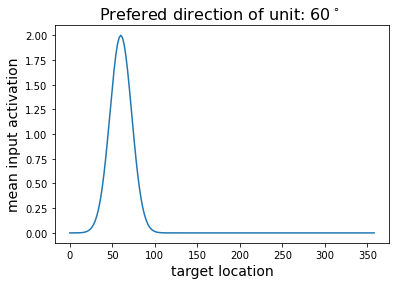

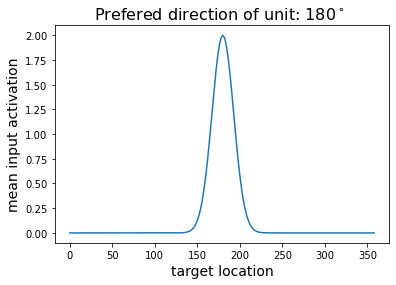

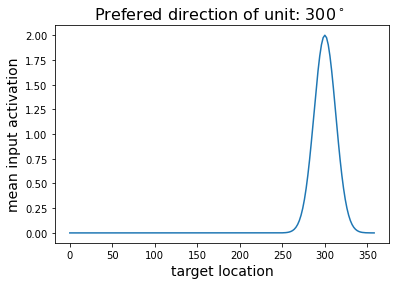

In [3]:
# Plot activation profile for and example unit

def plot_input_activation_profile(prefered_direction, baseline=0, gain=1, spread=12):
    # calculate activation for all orientations between 0 and 360 degrees
    target = np.arange(0,360,2)
    activation = np.zeros(len(target))

    for ii in range(len(target)):
        activation[ii] = input_activation(target[ii], prefered_direction, 
                                          baseline=baseline, gain=gain, spread=spread)

    # plot input activation    
    ax, fig = plt.subplots()
    plt.plot(target, activation)
    plt.xlabel('target location', fontsize=14)
    plt.ylabel('mean input activation', fontsize=14)
    plt.title('Prefered direction of unit: %d$^\circ$ ' %prefered_direction, fontsize=16)
    
for pref in[60, 180, 300]:
    plot_input_activation_profile(pref, baseline=0, gain=2, spread=30)

### Trial iteration
#### equation (8)

Add Gaussian noise to input activation

### Lateral connection strength
#### equation (9)

The initial connection strength between a pair of units is determined by the distance between the units’ preferred directions in the circular space (preferred directions were evenly spaced at delta = 2 degrees)  

###### variables
W_ij: *$W_{ij}$* lateral connection strength (unit j to unit i)  
pref_i: *$\theta_i^*$*, prefered direction of unit i  
pref_j: *$\theta_j^*$*, prefered direction of unit j  
spread: *$\omega_L$*, full-width-half-magnitude (FWHM)

In [4]:
# define lateral connection strength function

def connection_strength(pref_i, pref_j, spread=30):
    W_ij = np.exp(-np.log(2) * ((pref_i-pref_j) / (spread/2))**2)    
    return W_ij

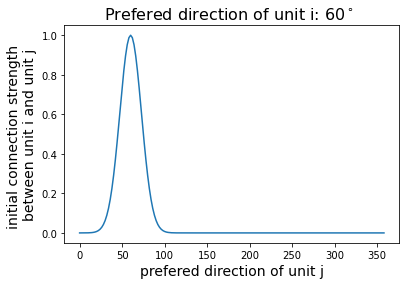

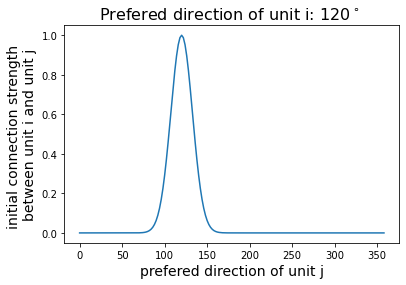

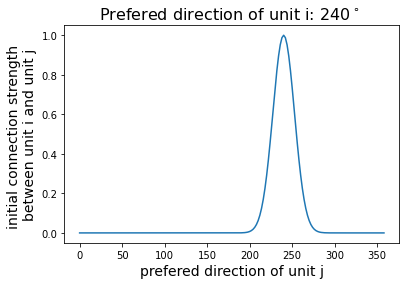

In [5]:
# Plot activation profile for and example unit

def plot_connection_strength_profile(pref_i, spread=12):
    # calculate connection
    pref_j = np.arange(0,360,2)
    W_ij = np.zeros(len(pref_j))

    for j in range(len(pref_j)):
        W_ij[j] = connection_strength(pref_i, pref_j[j], spread)

    # plot input activation    
    ax, fig = plt.subplots()
    plt.plot(pref_j, W_ij)
    plt.xlabel('prefered direction of unit j', fontsize=14)
    plt.ylabel('initial connection strength \nbetween unit i and unit j', fontsize=14)
    plt.title('Prefered direction of unit i: %d$^\circ$ ' %pref_i, fontsize=16)
    
for pref_i in[60, 120, 240]:
    plot_connection_strength_profile(pref_i, spread=30)

In [6]:
def calc_initial_weights(pref_dirs, spread=30):

    # calc weight between units
    initial_weights = np.zeros([len(pref_dirs), len(pref_dirs)])
    for i, pref_i in enumerate(pref_dirs):
        for j, pref_j in enumerate(pref_dirs):
            initial_weights[i,j] = connection_strength(i, j, spread=spread)
            
    return initial_weights
           

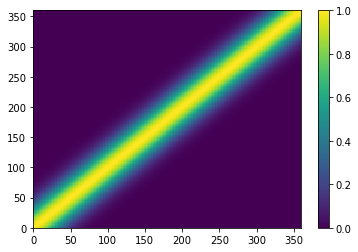

In [7]:
# create and plot an example initial weight matrix

# calc initial weights
pref_dirs = np.linspace(0,360,180)
initial_weights = calc_initial_weights(pref_dirs, spread=30)

# plot weights
plt.pcolormesh(pref_dirs, pref_dirs, initial_weights)
plt.colorbar()

### Total Activation
#### equation (10)

On each iteration *t*, the total activation for unit *i* was then computed as the sum of the input and recurrent activations

In [8]:
def total_activation(firing_rate, weights, theta, preference, 
                     baseline=0, gain=1E3, spread=12):    
    # calc total activation
    activation = input_activation(theta, preference, baseline=baseline, gain=gain, spread=spread)
    recurrent = np.dot(weights, firing_rate)
    total_activation = activation + recurrent
    
    return total_activation


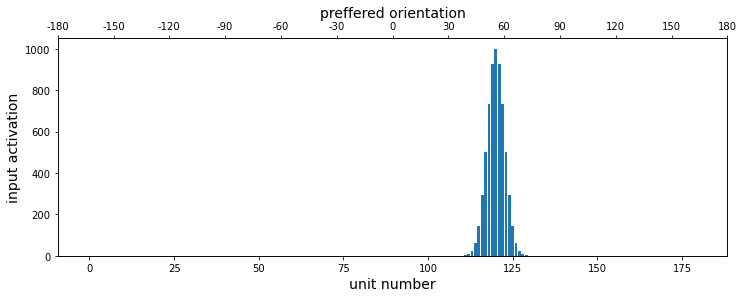

In [9]:
# calc input activation example

# define input angle
THETA = 60 

# define 180 units, assign preference
preference = np.arange(-180,180,2) # prefered angle
X = np.zeros_like(preference) # firing rates

# calculate input activation of each unit
U = lambda preference: total_activation(X, initial_weights, THETA, preference)
act = U(preference)

# plot input activation of each unit
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.bar(np.arange(180), act)

ax1.set_xlabel('unit number', fontsize=14)
ax1.set_ylabel('input activation', fontsize=14)

xx = np.linspace(-180,180,13)
ax2.set_xticks(xx)
ax2.set_xticklabels([str(int(x)) for x in xx] )
ax2.set_xlabel('preffered orientation', fontsize=14)
plt.show()

### Firing Rates
#### equation (11)

Total activation was normalized on each iteration to obtain the new firing rates

In [10]:
def norm_activation(activation, a=0.002, b=0.001):
    norm = np.zeros_like(activation)
    for ii, act in enumerate(activation):
        norm[ii] = act**2 / (a + b * np.sum(activation**2))
    return norm  

### Hebbian learning rule
#### equation (12) 

After each iteration, the recurrent weights Wij were updated using a
normalized Hebbian learning rule [(Oja, 1982)](https://link.springer.com/article/10.1007/BF00275687)

beta: *$\beta$* learning rate  
alpha: *$\alpha$* normalization parameter  
weights: *$W_{ij}$*, synaptic weights  
updated_weights: *$W_{ij, t+1}$*; updated weight  
X: firing rates

In [11]:
def update_weights(weights, X, beta=1E-5, alpha=1E-3):
    # calc new weights
    updated_weights = weights + beta*(np.outer(X, X) - (alpha*(weights*(X**2)).T))
    
    return updated_weights

Text(0.5, 1.0, 'updated weights')

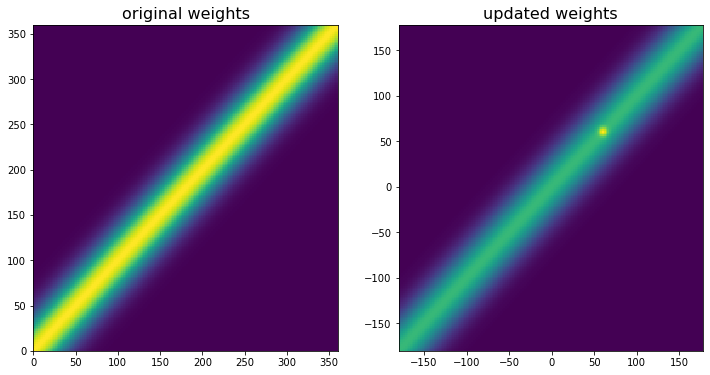

In [12]:
updated_weights = update_weights(initial_weights, norm_activation(act), 
                                 beta=1E-5, alpha=1E-3)

# plot weights
fig, ax = plt.subplots(1,2, figsize=[12,6])
ax[0].pcolormesh(pref_dirs, pref_dirs, initial_weights)
ax[0].set_title('original weights', fontsize=16)

# plot weights
ax[1].pcolormesh(preference, preference, updated_weights)
ax[1].set_title('updated weights', fontsize=16)

### Estimated Movement Vector
#### equation (13) 

[Georgopoulos, 1988](https://www.jneurosci.org/content/8/8/2928)


In [13]:
def decode_output(X, preference):
    # convert to degrees, decode output, convert back to degrees
    
    pref_rad = np.radians(preference)
    temp = np.arctan((np.sum(X*np.sin(pref_rad))) / (np.sum(X*np.cos(pref_rad))))
    output = np.degrees(temp)
        
    return output


## Build Adaptive Baysian model

In [14]:
# begin by building model with fixed weights

def calc_firing_rate(firing_rate, theta, preference, weights, 
                     baseline=0, gain=1E3, spread=12):
    
    # calc total activation
    activation = total_activation(firing_rate, weights, theta, preference, 
                                  baseline=baseline, gain=gain, spread=spread)

    # normalize activation
    firing_rate = norm_activation(activation)
    
    return firing_rate
       
def run_trial(initial_weights, pref_dirs, theta, n_iterations=5,
              baseline=0, gain=1E3, spread=30,
              beta=1E-5, alpha=1E-3):
    
    # initial conditions
    firing_rates = np.zeros([n_iterations+1, len(preference)])
    weights = np.zeros([n_iterations+1, initial_weights.shape[0], initial_weights.shape[1]])
    weights[0] = initial_weights

    # run 5 iterations
    for ii in np.arange(1,n_iterations+1):
        firing_rates[ii] = calc_firing_rate(firing_rates[ii-1], theta, preference, weights[ii-1],
                                            baseline=baseline, gain=gain, spread=spread)
        weights[ii] = update_weights(weights[ii-1], firing_rates[ii-1], beta=beta, alpha=alpha)
        
    # decode output
    output = decode_output(firing_rates[5], preference)
    
    return output, firing_rates, weights
   

In [15]:
# run an example trial

# define parameters
THETA = 45 # input angle
N_UNITS = 180 # number of units in network

# define units with evenly spaced preffered directions
pref_dirs = np.arange(-180,180,360/N_UNITS)

# define initial weight matrix
initial_weights = calc_initial_weights(pref_dirs, spread=30)

# run trial
output, firing_rates, weights = run_trial(initial_weights, pref_dirs, THETA,
                                          baseline=0, gain=1E3, spread=30,
                                          beta=1E-5, alpha=1E-3)

# print results
print('Target location: %d\N{DEGREE SIGN}' %THETA)
print('Decoded movement angle: %0.2f\N{DEGREE SIGN}' %output)


Target location: 45°
Decoded movement angle: 45.00°


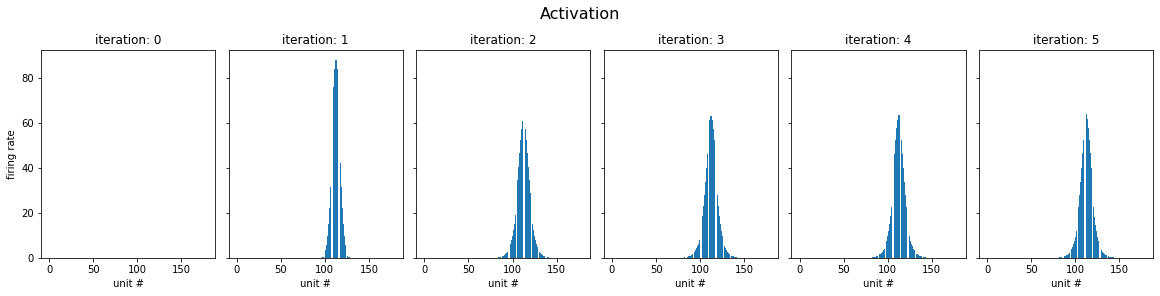

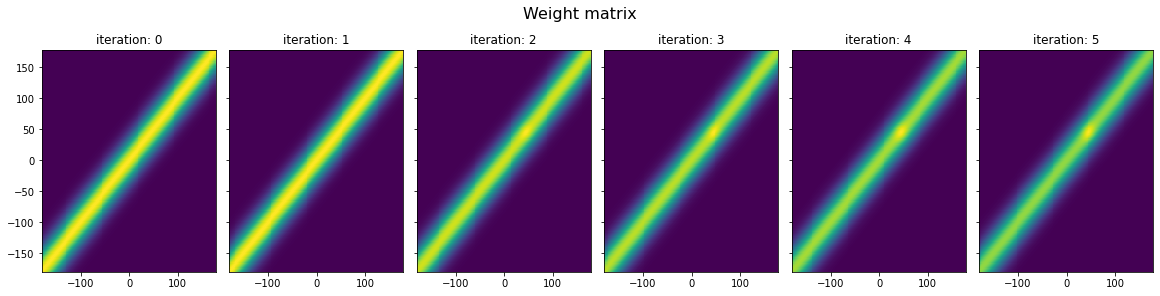

In [16]:
# plot evolution of firing rates
fig, ax = plt.subplots(1,6, figsize=[16,4], sharey='all', constrained_layout=True)
fig.suptitle('Activation', fontsize=16)
ax[0].set(ylabel='firing rate')
for i in range(firing_rates.shape[0]):
    # plot
    ax[i].bar(np.arange(N_UNITS), firing_rates[i])
    
    #label
    ax[i].set(xlabel='unit #')
    ax[i].set(title='iteration: %d' %i)
plt.show()

# plot evolution of weights
fig, ax = plt.subplots(1,6, figsize=[16,4], sharey='all', constrained_layout=True)
fig.suptitle('Weight matrix', fontsize=16)
for i in range(firing_rates.shape[0]):
    ax[i].pcolormesh(pref_dirs, pref_dirs, weights[i])
    ax[i].set(title='iteration: %d' %i)
plt.show()


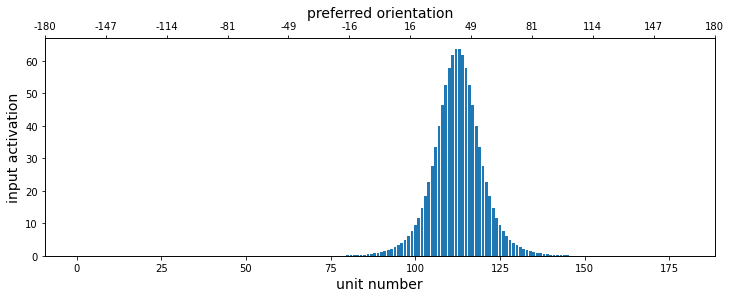

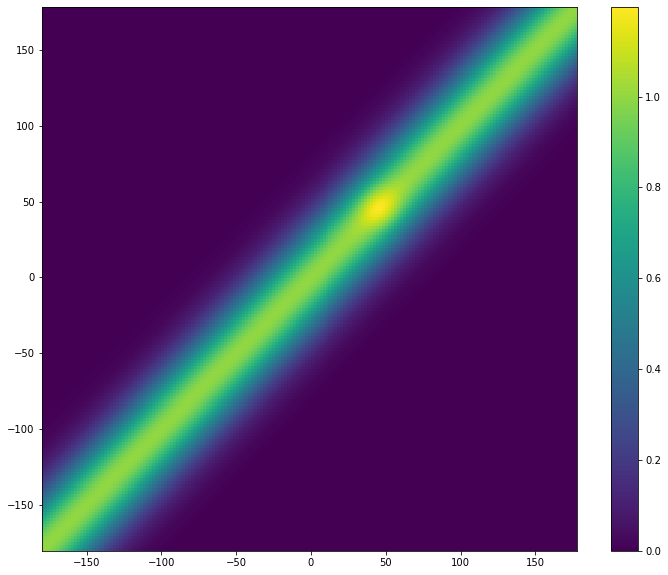

In [17]:
# plot final firing rates and weights on final interation of trial

# plot firing rates
# create figure
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
# plot data
ax1.bar(np.arange(N_UNITS), firing_rates[5])
# label plot
ax1.set_xlabel('unit number', fontsize=14)
ax1.set_ylabel('input activation', fontsize=14)
# add second x label
xx = np.linspace(pref_dirs[0],-pref_dirs[0], 12)
ax2.set_xticks(xx)
ax2.set_xticklabels([str(int(x)) for x in xx] )
ax2.set_xlabel('preferred orientation', fontsize=14)

# plot final weights
plt.figure(figsize=[12,10])
plt.pcolormesh(pref_dirs, pref_dirs, weights[5])
plt.colorbar()
plt.show()

## Let's run some consecutive trials

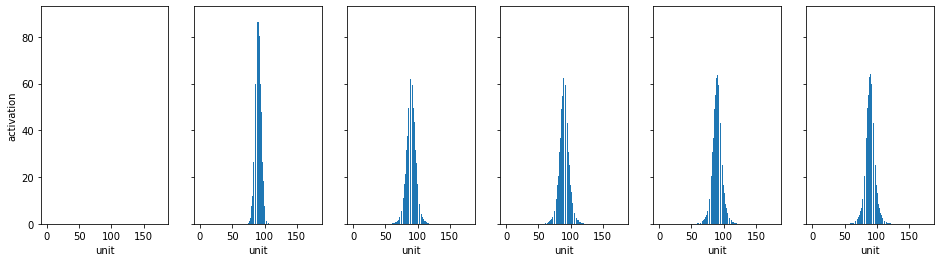

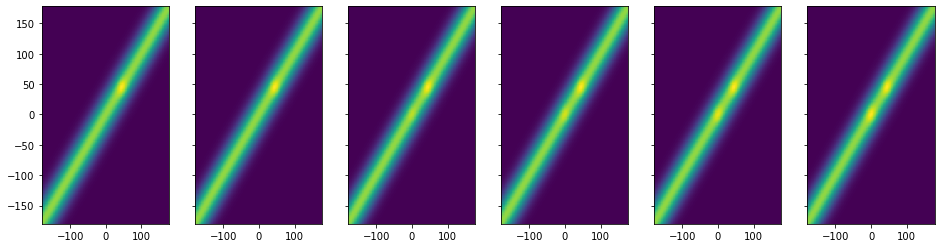

In [18]:
THETA = 0

# run trial
output, firing_rates_2, weights_2 = run_trial(weights[5], pref_dirs, THETA)

# plot evolution of firing rates
fig, ax = plt.subplots(1,6, figsize=[16,4], sharey='all')
ax[0].set(ylabel='activation')
for i in range(firing_rates.shape[0]):
    ax[i].bar(np.arange(180), firing_rates_2[i])
    ax[i].set(xlabel='unit')   
plt.show()

# plot evolution of weights
fig, ax = plt.subplots(1,6, figsize=[16,4], sharey='all')
for i in range(firing_rates.shape[0]):
    ax[i].pcolormesh(preference, preference, weights_2[i])
plt.show()